### Load data and Install Dependencies

In [ ]:
! unzip /content/drive/MyDrive/EEGDATA.zip -d /content/data/

Archive:  /content/drive/MyDrive/EEGDATA.zip
   creating: /content/data/EEGDATA/
   creating: /content/data/EEGDATA/RAW  DATA/
   creating: /content/data/EEGDATA/RAW  DATA/ASD GROUP/
  inflating: /content/data/EEGDATA/RAW  DATA/ASD GROUP/001.eeg  
  inflating: /content/data/EEGDATA/RAW  DATA/ASD GROUP/001.vhdr  
  inflating: /content/data/EEGDATA/RAW  DATA/ASD GROUP/001.vmrk  
  inflating: /content/data/EEGDATA/RAW  DATA/ASD GROUP/002.eeg  
  inflating: /content/data/EEGDATA/RAW  DATA/ASD GROUP/002.vhdr  
  inflating: /content/data/EEGDATA/RAW  DATA/ASD GROUP/002.vmrk  
  inflating: /content/data/EEGDATA/RAW  DATA/ASD GROUP/003.eeg  
  inflating: /content/data/EEGDATA/RAW  DATA/ASD GROUP/003.vhdr  
  inflating: /content/data/EEGDATA/RAW  DATA/ASD GROUP/003.vmrk  
  inflating: /content/data/EEGDATA/RAW  DATA/ASD GROUP/004.eeg  
  inflating: /content/data/EEGDATA/RAW  DATA/ASD GROUP/004.vhdr  
  inflating: /content/data/EEGDATA/RAW  DATA/ASD GROUP/004.vmrk  
  inflating: /content/data/EE

In [1]:
! pip install mne numpy pandas scikit-learn matplotlib seaborn tensorflow antropy
! pip freeze > requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 49.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras import layers, models

from antropy import sample_entropy, higuchi_fd, petrosian_fd
from scipy.stats import skew, kurtosis
from mne.time_frequency import psd_array_welch

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### Fixing .eeg and .vmrk file in .vhdr files and Some visualization

In [ ]:
def changeNames(folder):
  for filename in os.listdir(folder):
    if filename.endswith(".vhdr"):
        vhdr_path = os.path.join(folder, filename)
        base_name = os.path.splitext(filename)[0]
        correct_eeg = f"{base_name}.eeg"
        correct_vmrk = f"{base_name}.vmrk"

        with open(vhdr_path, "r", encoding="utf-8") as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            if line.strip().lower().startswith("datafile="):
                new_lines.append(f"DataFile={correct_eeg}\n")
            elif line.strip().lower().startswith("markerfile="):
                new_lines.append(f"MarkerFile={correct_vmrk}\n")
            else:
                new_lines.append(line)

        with open(vhdr_path, "w", encoding="utf-8") as f:
            f.writelines(new_lines)

In [ ]:
asd = "/content/data/ASD"
td = "/content/data/TD"
changeNames(asd)
changeNames(td)

In [ ]:
vhdr_file = "/content/data/ASD/007.vhdr"
raw1 = mne.io.read_raw_brainvision(vhdr_file, preload=True)
print(raw1.info)


In [ ]:
print(raw1.info['ch_names'])

In [ ]:
# Plot the EEG signal
raw1.plot(n_channels=32, duration=10, scalings='auto', title='EEG Data')
raw1.set_channel_types({'EOG': 'eog'})
raw1.copy().pick_types(eog=True).plot()
print("hello")


In [ ]:
raw1.plot_psd(fmax=50)
print("hello")

In [ ]:
events, event_id = mne.events_from_annotations(raw1)
mne.viz.plot_events(events, sfreq=raw1.info['sfreq'], first_samp=raw1.first_samp)
print("h")


### Resampling, Filtering and Segmenting EEG signals

In [ ]:
def load_eeg_data(folder, label, target_sampling_rate):
    data = []
    labels = []
    for file in os.listdir(folder):
        print(file)
        if file.endswith(".vhdr"):
            vhdr_path = os.path.join(folder, file)
            raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)
            raw.pick_types(eeg=True)
            raw.resample(target_sampling_rate)
            raw.filter(1., 40., fir_design = "firwin")

            tmin = -0.2
            tmax = 0.792
            events, event_id = mne.events_from_annotations(raw)
            epochs = mne.Epochs(raw, events, event_id=event_id,
                                tmin=tmin, tmax=tmax,
                                baseline=(None, 0), preload=True, verbose=False, event_repeated='drop')

            X = epochs.get_data()  # (n_epochs, n_channels, n_times)
            y = np.full((X.shape[0],), label)  # all segments get same subject label

            data.append(list(X))
            labels.append(label)
    return data, labels

In [ ]:
def load_all_data(data_path, target_sampling_rate):
    asd_data, asd_labels = load_eeg_data(os.path.join(data_path, "ASD"), 1, target_sampling_rate)
    td_data, td_labels = load_eeg_data(os.path.join(data_path, "TD"), 0, target_sampling_rate)
    return asd_data, asd_labels, td_data, td_labels

In [ ]:
data_path = "/content/data"
target_sampling_rate = 128

asd_data, asd_labels, td_data, td_labels = load_all_data(data_path, target_sampling_rate)

004.vmrk
006.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  6')]
013.vmrk
005.vmrk
001.eeg
014.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
008.eeg
010.eeg
011.vmrk
014.vmrk
008.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5')]
015.eeg
015.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
001.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
003.vmrk
009.vmrk
004.eeg
011.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
003.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
010.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  6')]
003.eeg
002.vmrk
005.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
002.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
014.eeg
011.eeg
012.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
002.eeg
006.vmrk
013.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
005.eeg
007.eeg
001.vmrk
012.vmrk
015.vmrk
008.vmrk
006.eeg
012.eeg
009.eeg
009.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
010.vmrk
007.vmrk
004.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5')]
007.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
013.eeg
004.vmrk
006.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
013.vmrk
017.eeg
005.vmrk
001.eeg
014.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
008.eeg
010.eeg
011.vmrk
014.vmrk
019.eeg
008.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
015.eeg
015.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
001.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
003.vmrk
009.vmrk
004.eeg
011.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  6')]
003.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
010.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
003.eeg
002.vmrk
017.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
005.vhdr
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
------

/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  6')]
016.vmrk
014.eeg
011.eeg
016.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
012.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
002.eeg
006.vmrk
013.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5')]
018.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
005.eeg
007.eeg
018.vmrk
001.vmrk
019.vmrk
012.vmrk
015.vmrk
018.eeg
019.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
008.vmrk
006.eeg
016.eeg
012.eeg
009.eeg
009.vhdr


/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
010.vmrk
007.vmrk
017.vmrk
004.vhdr
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

F

/tmp/ipython-input-1054754203.py:8: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4')]
013.eeg


In [ ]:
asd_data = [sublist[: 800] for sublist in asd_data]
td_data = [sublist[: 800] for sublist in td_data]

asd_data = np.array(asd_data)
td_data = np.array(td_data)
asd_labels = np.array(asd_labels)
td_labels = np.array(td_labels)

X_subj = np.concatenate((asd_data, td_data))
y_subj = np.concatenate((asd_labels, td_labels))

X_train_subj, X_test_subj, y_train_subj, y_test_subj = train_test_split(
   X_subj, y_subj, test_size=0.2, random_state=42, stratify=y_subj)

X_train = np.vstack(X_train_subj)
y_train = np.hstack([
    np.full(len(subject_epochs), label)
    for subject_epochs, label in zip(X_train_subj, y_train_subj)
])

X_test = np.vstack(X_test_subj)
y_test = np.hstack([
    np.full(len(subject_epochs), label)
    for subject_epochs, label in zip(X_test_subj, y_test_subj)
])

print(X_test_subj.shape)

(7, 800, 64, 128)


###FEATURE EXTRACTION

In [ ]:
# Frequency Domain (Band Power)

bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45),
}

def extract_band_power(epoch, sfreq):
    psd, freqs = psd_array_welch(epoch, sfreq=sfreq, fmin=0.5, fmax=45, n_fft=256, n_per_seg=128)
    band_features = {}
    for band, (low, high) in bands.items():
        idx = (freqs >= low) & (freqs <= high)
        band_features[f'{band}_power'] = np.mean(psd[:, idx], axis=1)
    return band_features


In [ ]:
# Time domain (skewness and kurtosis (statistical))

def extract_statistical_features(epoch):
    return {
        'skewness': skew(epoch, axis=1),
        'kurtosis': kurtosis(epoch, axis=1),
    }

In [ ]:
# Sample Entropy

def extract_entropy_features(epoch):
    return {
        'sample_entropy': np.array([sample_entropy(ch) for ch in epoch]),
    }

In [ ]:
# Fractal Dimensions

def extract_fractal_features(epoch):
    return {
        'higuchi_fd': np.array([higuchi_fd(ch) for ch in epoch]),
        'petrosian_fd': np.array([petrosian_fd(ch) for ch in epoch]),
    }

In [ ]:
def extract_features_from_epoch(epoch, sfreq):
    features = []
    feature_sets = {
        **extract_band_power(epoch, sfreq),
        **extract_statistical_features(epoch),
        **extract_entropy_features(epoch),
        **extract_fractal_features(epoch)
    }
    for key, val in feature_sets.items():
         features.append(np.mean(val))

    return features

In [ ]:
sfreq = target_sampling_rate

X_features_train = []
count = 1
for epoch in X_train :
  X_features_train.append(list(extract_features_from_epoch(epoch, sfreq)))
  print(count)
  count += 1

X_features_test = []
count = 1
for epoch in X_test :
  X_features_test.append(list(extract_features_from_epoch(epoch, sfreq)))
  print(count)
  count += 1

Streaming output truncated to the last 5000 lines.
Effective window size : 2.000 (s)
3101
Effective window size : 2.000 (s)
3102
Effective window size : 2.000 (s)
3103
Effective window size : 2.000 (s)
3104
Effective window size : 2.000 (s)
3105
Effective window size : 2.000 (s)
3106
Effective window size : 2.000 (s)
3107
Effective window size : 2.000 (s)
3108
Effective window size : 2.000 (s)
3109
Effective window size : 2.000 (s)
3110
Effective window size : 2.000 (s)
3111
Effective window size : 2.000 (s)
3112
Effective window size : 2.000 (s)
3113
Effective window size : 2.000 (s)
3114
Effective window size : 2.000 (s)
3115
Effective window size : 2.000 (s)
3116
Effective window size : 2.000 (s)
3117
Effective window size : 2.000 (s)
3118
Effective window size : 2.000 (s)
3119
Effective window size : 2.000 (s)
3120
Effective window size : 2.000 (s)
3121
Effective window size : 2.000 (s)
3122
Effective window size : 2.000 (s)
3123
Effective window size : 2.000 (s)
3124
Effective win

In [ ]:
X_features_test = np.array(X_features_test)
X_features_train = np.array(X_features_train)

#X_features_test = X_features_test.reshape(7, 800, 10)
print(X_features_test.shape)
print(X_features_train.shape)

(5600, 10)
(21600, 10)


Subject-level accuracy: 0.5430357142857143

Classification report:
               precision    recall  f1-score   support

           0       0.57      0.79      0.66      3200
           1       0.43      0.21      0.28      2400

    accuracy                           0.54      5600
   macro avg       0.50      0.50      0.47      5600
weighted avg       0.51      0.54      0.50      5600



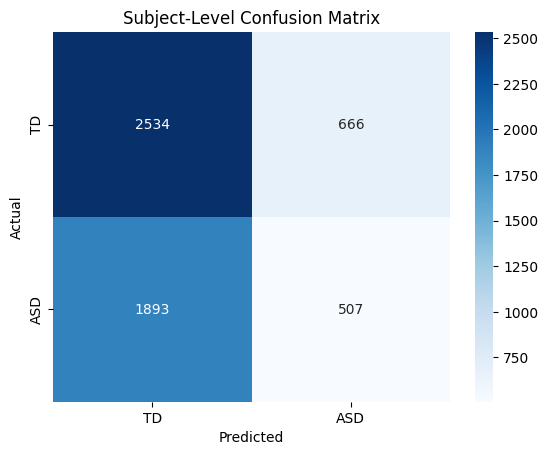

In [ ]:
#clf = LogisticRegression(max_iter=1000)
#clf = SVC(kernel='linear', probability=True, verbose=True)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
#clf = LinearDiscriminantAnalysis()
clf.fit(X_features_train, y_train)

subject_preds = []
# for data_point in X_features_test:
#     # Predict for all epochs of this subject
#     data_pred = clf.predict(data_point)  # shape: (n_epochs,)

#     # Majority voting
#     #subject_label = 1 if data_pred = 1 else 0
#     subject_preds.append(data_pred)

subject_preds = clf.predict(X_features_test)

print("Subject-level accuracy:", accuracy_score(y_test, subject_preds))
print("\nClassification report:\n", classification_report(y_test, subject_preds))

cm = confusion_matrix(y_test, subject_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['TD', 'ASD'], yticklabels=['TD', 'ASD'])
plt.title("Subject-Level Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
clf = LogisticRegression(max_iter=1000)
#clf = SVC(kernel='linear', probability=True)
#clf = LinearDiscriminantAnalysis()
clf.fit(X_features_train, y_train)

# 3. Predict on test set
y_pred = clf.predict(X_features_test)
y_proba = clf.predict_proba(X_features_test)[:, 1]

# 4. Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# 5. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['TD', 'ASD'], yticklabels=['TD', 'ASD'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 6. ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
def build_cnn(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, 7, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, 5, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def build_lstm(input_shape):
    model = models.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        layers.LSTM(32),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def build_gru(input_shape):
    model = models.Sequential([
        layers.GRU(64, return_sequences=True, input_shape=input_shape),
        layers.GRU(32),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test).ravel()
    y_pred_labels = (y_pred > 0.5).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{name} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

    print(classification_report(y_test, y_pred_labels, target_names=['TD', 'ASD']))

In [ ]:
def train_and_evaluate(model_fn, X_train, y_train, X_test, y_test, name):
    print(f"\nTraining {name}...")
    model = model_fn((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=20, batch_size=8, validation_split=0.1, verbose=1)
    evaluate_model(model, X_test, y_test, name)
    return model


Training CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5568 - loss: 0.6880 - val_accuracy: 0.5488 - val_loss: 0.6885
Epoch 2/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.5586 - loss: 0.6864 - val_accuracy: 0.5488 - val_loss: 0.6868
Epoch 3/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5574 - loss: 0.6827 - val_accuracy: 0.5969 - val_loss: 0.6657
Epoch 4/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5958 - loss: 0.6687 - val_accuracy: 0.6033 - val_loss: 0.6627
Epoch 5/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6037 - loss: 0.6610 - val_accuracy: 0.6180 - val_loss: 0.6583
Epoch 6/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6129 - loss: 0.6574 - val_accuracy: 0.6097 - val_loss: 0.6578
Epoch 7/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6110 - loss: 0.6564 - val_accuracy: 0.6221 - val_loss: 0.6533
Epoch 8/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6128 - loss: 0.6562 

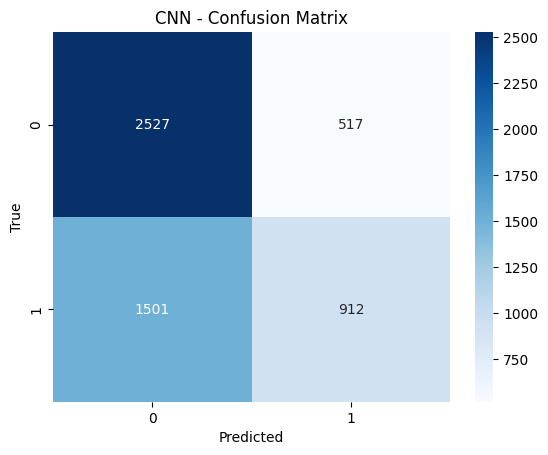

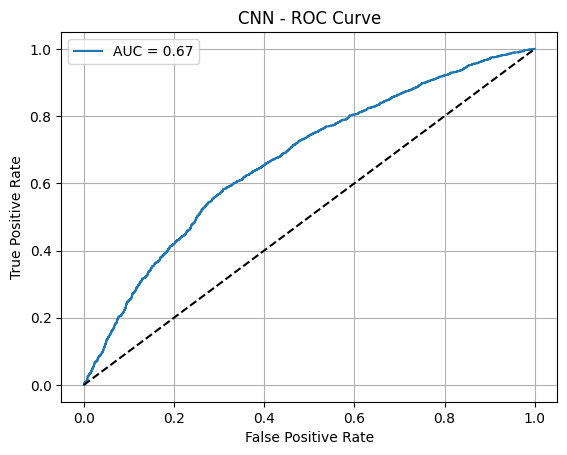

              precision    recall  f1-score   support

          TD       0.63      0.83      0.71      3044
         ASD       0.64      0.38      0.47      2413

    accuracy                           0.63      5457
   macro avg       0.63      0.60      0.59      5457
weighted avg       0.63      0.63      0.61      5457


Training LSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.5528 - loss: 0.6881 - val_accuracy: 0.5488 - val_loss: 0.6885
Epoch 2/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.5600 - loss: 0.6862 - val_accuracy: 0.5488 - val_loss: 0.6887
Epoch 3/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.5586 - loss: 0.6867 - val_accuracy: 0.5488 - val_loss: 0.6889
Epoch 4/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.5635 - loss: 0.6853 - val_accuracy: 0.5488 - val_loss: 0.6884
Epoch 5/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.5622 - loss: 0.6858 - val_accuracy: 0.5488 - val_loss: 0.6887
Epoch 6/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.5578 - loss: 0.6867 - val_accuracy: 0.5488 - val_loss: 0.6884
Epoch 7/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.5570 - loss: 0.6868 - val_accuracy: 0.5488 - val_loss: 0.6889
Epoch 8/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.5591 -

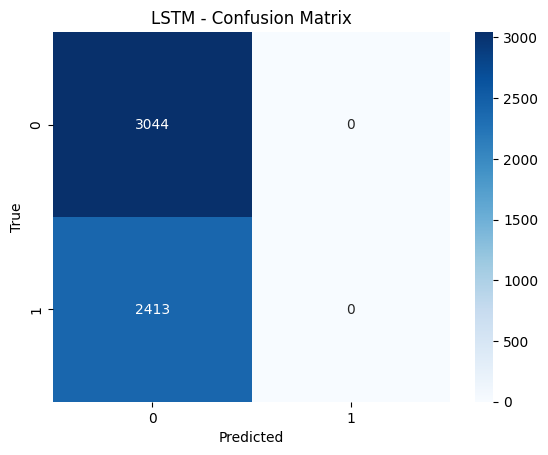

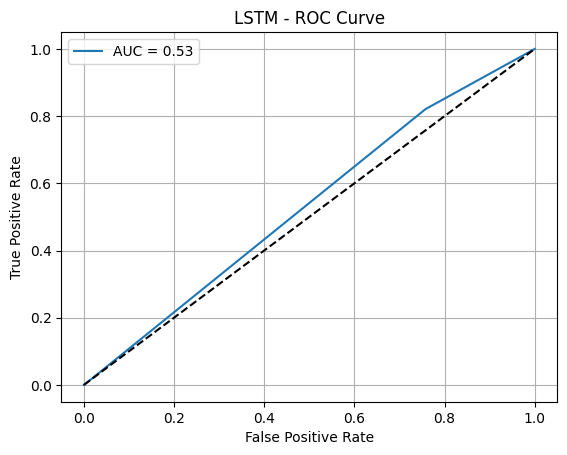

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

              precision    recall  f1-score   support

          TD       0.56      1.00      0.72      3044
         ASD       0.00      0.00      0.00      2413

    accuracy                           0.56      5457
   macro avg       0.28      0.50      0.36      5457
weighted avg       0.31      0.56      0.40      5457


Training GRU...
Epoch 1/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.5555 - loss: 0.6882 - val_accuracy: 0.5488 - val_loss: 0.6885
Epoch 2/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.5554 - loss: 0.6873 - val_accuracy: 0.5488 - val_loss: 0.6886
Epoch 3/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.5587 - loss: 0.6865 - val_accuracy: 0.5488 - val_loss: 0.6887
Epoch 4/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.5549 - loss: 0.6874 - val_accuracy: 0.5488 - val_loss: 0.6884
Epoch 5/20
2456/2456 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.5575 - loss: 0.6869 - val_accuracy: 0.5488 - val_loss: 0.6

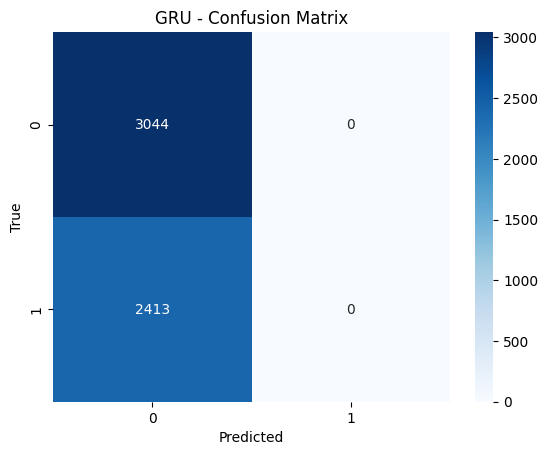

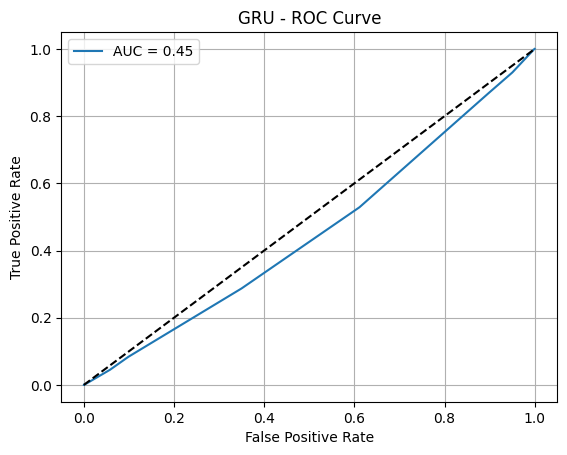

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

          TD       0.56      1.00      0.72      3044
         ASD       0.00      0.00      0.00      2413

    accuracy                           0.56      5457
   macro avg       0.28      0.50      0.36      5457
weighted avg       0.31      0.56      0.40      5457


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.86      0.68      3044
           1       0.46      0.15      0.23      2413

    accuracy                           0.55      5457
   macro avg       0.51      0.50      0.45      5457
weighted avg       0.52      0.55      0.48      5457



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train deep learning models
cnn_model = train_and_evaluate(build_cnn, X_train, y_train, X_test, y_test, 'CNN')
lstm_model = train_and_evaluate(build_lstm, X_train, y_train, X_test, y_test, 'LSTM')
gru_model = train_and_evaluate(build_gru, X_train, y_train, X_test, y_test, 'GRU')

# Classical ML Models
X_flat = X.reshape(X.shape[0], -1)  # flatten for classical models
X_train_flat, X_test_flat = X_flat[y_train.shape[0]*-1:], X_flat[:y_train.shape[0]*-1]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_flat, y_train)
y_pred_rf = rf.predict(X_test_flat)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

svm = SVC(probability=True, kernel='rbf')
svm.fit(X_train_flat, y_train)
y_pred_svm = svm.predict(X_test_flat)
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))